In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

## data cleaning

In [2]:
# data is already pre-processed, just handling the target value
df = pd.read_excel('processed_data1.2.xlsx', header = None)
df.fillna(-999999, inplace = True)
y = df.iloc[:, 1367]
x = np.array(df.drop(1367, axis = 1).astype(float))
y = y.str.replace(r'(^.*High.*$)', '3')
y = y.str.replace(r'(^.*Low.*$)', '2')
y = y.str.replace(r'(^.*Norm.*$)', '1')
y = np.array(y.astype(float))

## K-Means unsupervised


In [3]:
from sklearn.cluster import KMeans

for _ in range(10):
    clf_km = KMeans(n_clusters = 3)
    clf_km.fit(x)


    correct = 0
    for i in range(len(x)):
        predict_me = np.array(x[i].astype(float))
        predict_me = predict_me.reshape(-1, len(predict_me))
        prediction = clf_km.predict(predict_me)
    
        if prediction[0] == y[i]:
            correct += 1
    print(correct/len(x))

0.07407407407407407
0.2191358024691358
0.32407407407407407
0.037037037037037035
0.32407407407407407
0.037037037037037035
0.05864197530864197
0.037037037037037035
0.05864197530864197
0.32407407407407407


## Fuzzy-Kmeans

In [4]:
from sklearn_extensions.fuzzy_kmeans import FuzzyKMeans, KMedians


clf_fkm = FuzzyKMeans(k = 3, m = 2)
clf_fkm.fit(x)
correct = 0
for i in range(len(x)):
    if clf_fkm.labels_[i] == y[i]:
        correct += 1
print(correct/len(x))

0.15123456790123457


## Logistic Regression 10-fold CV

In [5]:
from sklearn.model_selection import cross_val_score
clf_lr = LogisticRegression()
scores = cross_val_score(clf_lr, x, y, cv = 10)
print(scores)   
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


[0.90909091 0.81818182 0.81818182 0.75757576 0.6969697  0.75757576
 0.84375    0.75       0.93548387 0.64516129]
Accuracy: 0.79 (+/- 0.17)


## Linear SVM

In [6]:
clf_svm = svm.SVC(kernel = 'linear')
scores = cross_val_score(clf_svm, x, y, cv = 10)
print(scores)   
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.90909091 0.90909091 0.90909091 0.81818182 0.72727273 0.78787879
 0.9375     0.90625    0.96774194 0.64516129]
Accuracy: 0.85 (+/- 0.20)


## PCA

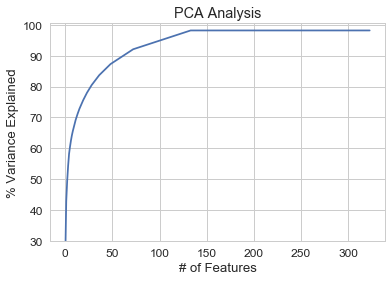

The first 41 PCs explained over 85% variance


In [7]:
from sklearn.decomposition import PCA
import seaborn as sb
%matplotlib inline
sb.set(font_scale=1.2,style="whitegrid") #set styling preferences

covar_matrix = PCA()

covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show()
num = np.argmax(var>85)
print('The first', num, 'PCs explained over 85% variance')

In [8]:
print(covar_matrix.components_[:41,:].shape)

(41, 1367)


In [9]:
pca = PCA(n_components = 41)
pca.fit(x)
new_x = pca.transform(x)
print(x.shape, new_x.shape)


(324, 1367) (324, 41)


[]

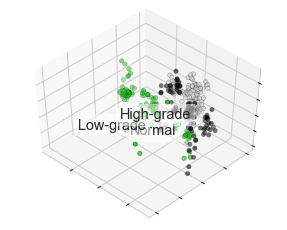

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
for name, label in [('Normal', 1), ('Low-grade', 2), ('High-grade',3)]:
    ax.text3D(new_x[y == label, 0].mean(),
              new_x[y == label, 1].mean() + 1.5,
              new_x[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [1, 2, 3]).astype(np.float)
ax.scatter(new_x[:, 0], new_x[:, 1], new_x[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

## PCA KMeans

In [11]:
for _ in range(10):
    clf_km = KMeans(n_clusters = 3)
    clf_km.fit(new_x)


    correct = 0
    for i in range(len(x)):
        predict_me = np.array(new_x[i].astype(float))
        predict_me = predict_me.reshape(-1, len(predict_me))
        prediction = clf_km.predict(predict_me)
    
        if prediction[0] == y[i]:
            correct += 1
    print(correct/len(new_x))

0.44753086419753085
0.07407407407407407
0.07407407407407407
0.44753086419753085
0.05864197530864197
0.2191358024691358
0.44753086419753085
0.07407407407407407
0.07407407407407407
0.44753086419753085


In [12]:
clf_fkm = FuzzyKMeans(k = 3, m = 2)
clf_fkm.fit(new_x)
correct = 0
for i in range(len(new_x)):
    if clf_fkm.labels_[i] == y[i]:
        correct += 1
print(correct/len(new_x))

0.11419753086419752


In [13]:
clf_lr = LogisticRegression()
scores = cross_val_score(clf_lr, new_x, y, cv = 10)
print(scores)   
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.90909091 0.81818182 0.81818182 0.75757576 0.6969697  0.78787879
 0.8125     0.78125    0.93548387 0.64516129]
Accuracy: 0.80 (+/- 0.16)


In [14]:
clf_svm = svm.SVC(kernel = 'linear')
scores = cross_val_score(clf_svm, new_x, y, cv = 10)
print(scores)   
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.90909091 0.84848485 0.90909091 0.75757576 0.6969697  0.78787879
 0.90625    0.8125     0.93548387 0.67741935]
Accuracy: 0.82 (+/- 0.18)
